In [3]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/data/.virtualenvs/fma/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]=""
import utils, optimization, metrics, plot

# Parameters

In [5]:
spix = 256
path = '../data/size{}_splits1000_n500x3/'.format(spix)
input_pattern = 'Box_70*snapshot_050'
file_ext = '.dat'
k = 10

# Data handling

Load the data

In [6]:
queue = []
for file in os.listdir(path):
    if file.endswith(file_ext) and (np.all([x in file for x in input_pattern.split("*")])):
        queue.append(os.path.join(path, file))
nsamples = len(queue)
print('They are {} "{}" files.'.format(nsamples, file_ext))      

They are 15000 ".dat" files.


In [7]:
nsamples = 1000
input_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(nsamples)))
input_img.resize([nsamples,spix,spix])


In [8]:
input_img = utils.forward_map(input_img,k)

# input_img = np.log(input_img+0.001)

# p = np.random.permutation(nsamples)
# input_img = input_img[p,]

Let us make small patches of 64 :-)

In [9]:
ns = 64
cut = spix//ns
img_small = np.zeros([nsamples*cut*cut, ns, ns])
for i in range(cut):
    for j in range(cut):
        k = j + i*cut 
        img_small[k*nsamples:(k+1)*nsamples,:,:] = input_img[:,i*ns:(i+1)*ns,j*ns:(j+1)*ns]


# # Reduce the size
# ns = 64
# cut = spix//ns
# img_small = input_img[:,:ns,:ns].copy()
# del input_img

# A) Load the model

In [30]:
import pickle
from model import *
from gan import *

# pathgan = '../../saved_result/GAN/2018_1_4_17_16_size_64/checkpoints/'
# pathgan = '../../saved_result/GAN/2018_1_5_11_29_size_64/checkpoints/'
pathgan = '../../saved_result/GAN/2018_1_7_0_49_size_64/checkpoints/'

# pathgan = '../../saved_result/WVEEGAN/2018_1_5_11_26_size_64/checkpoints/'
# pathgan = '../../saved_result/WVEEGAN/2018_1_6_0_12_size_64/checkpoints/'
# pathgan = '../../saved_result/WVEEGAN/2018_1_7_0_49_size_64/checkpoints/'



with open(pathgan+'params.pkl', 'rb') as f:
    params = pickle.load(f)
with open(pathgan+'model.pkl', 'rb') as f:
    model = pickle.load(f)
obj = WGAN(params, model)
# obj = WVEEGAN(params, model)


Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 4096 outputs
         Size of the variables: (?, 4096)
     Reshape to (?, 8, 8, 64)
     1 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 16, 16, 64)
     2 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 32, 32, 64)
     3 Deconv layer with 32 channels
         Batch norm
         Size of the variables: (?, 64, 64, 32)
     4 Deconv layer with 1 channels
         Size of the variables: (?, 64, 64, 1)
    Non lienarity: tanh
     The output is of size (?, 64, 64, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 64, 64, 1)
     0 Conv layer with 8 channels
         Batch norm
         Size of the variables: (?, 32, 32, 8)
     1 Conv layer with 64 channels
      

In [31]:
N = 500
checkpoints = None
# checkpoints = '16000'

if checkpoints is None:
    gen_sample, gen_sample_raw = obj.generate(N=N)
else:
    file_name = '../../saved_result/WVEEGAN/2018_1_7_0_49_size_64/checkpoints/'+model.name+'-'+checkpoints
    gen_sample, gen_sample_raw = obj.generate(N=N, file_name=file_name)

real_sample_raw = utils.backward_map(img_small[:N],k=k)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../saved_result/GAN/2018_1_7_0_49_size_64/checkpoints/gan-66000


INFO:tensorflow:Restoring parameters from ../../saved_result/GAN/2018_1_7_0_49_size_64/checkpoints/gan-66000


In [32]:
import metrics

psd_gen, x = metrics.power_spectrum_batch_phys(X1=gen_sample_raw)
psd_real, x = metrics.power_spectrum_batch_phys(X1=real_sample_raw)


def psd_metric(gen_sample_raw, real_sample_raw):
    psd_gen, _ = metrics.power_spectrum_batch_phys(X1=gen_sample_raw)
    psd_real, _ = metrics.power_spectrum_batch_phys(X1=real_sample_raw)
    psd_gen = np.mean(psd_gen, axis=0)    
    psd_real = np.mean(psd_real, axis=0)
    e = psd_real - psd_gen
    l2 = np.mean(e*e)
    loge = 10*(log10(psd_real+1e-5) - log10(psd_gen+1e-5))
    logel2 = np.mean(loge*loge)
    return l2, logel2
l2, logel2 = psd_metric(gen_sample_raw, real_sample_raw)


In [33]:
logel2, l2

(8.4797173758601385, 377179.70724896266)

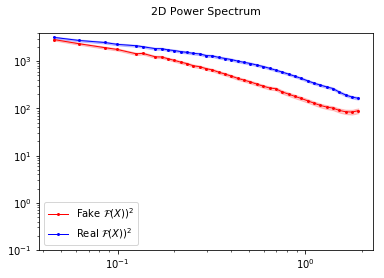

In [15]:
fig = plt.Figure()
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")
linestyle = {"linewidth": 1, "markeredgewidth": 0, "markersize": 3, "marker": "o", "linestyle": "-"}

plot.plot_with_shade(ax, x, psd_gen, color='r', label="Fake $\mathcal{F}(X))^2$", **linestyle)
plot.plot_with_shade(ax, x, psd_real, color='b', label="Real $\mathcal{F}(X))^2$", **linestyle)
ax.set_ylim(bottom=0.1)
ax.title.set_text("2D Power Spectrum\n")
ax.title.set_fontsize(11)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend()


/data/.virtualenvs/fma/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


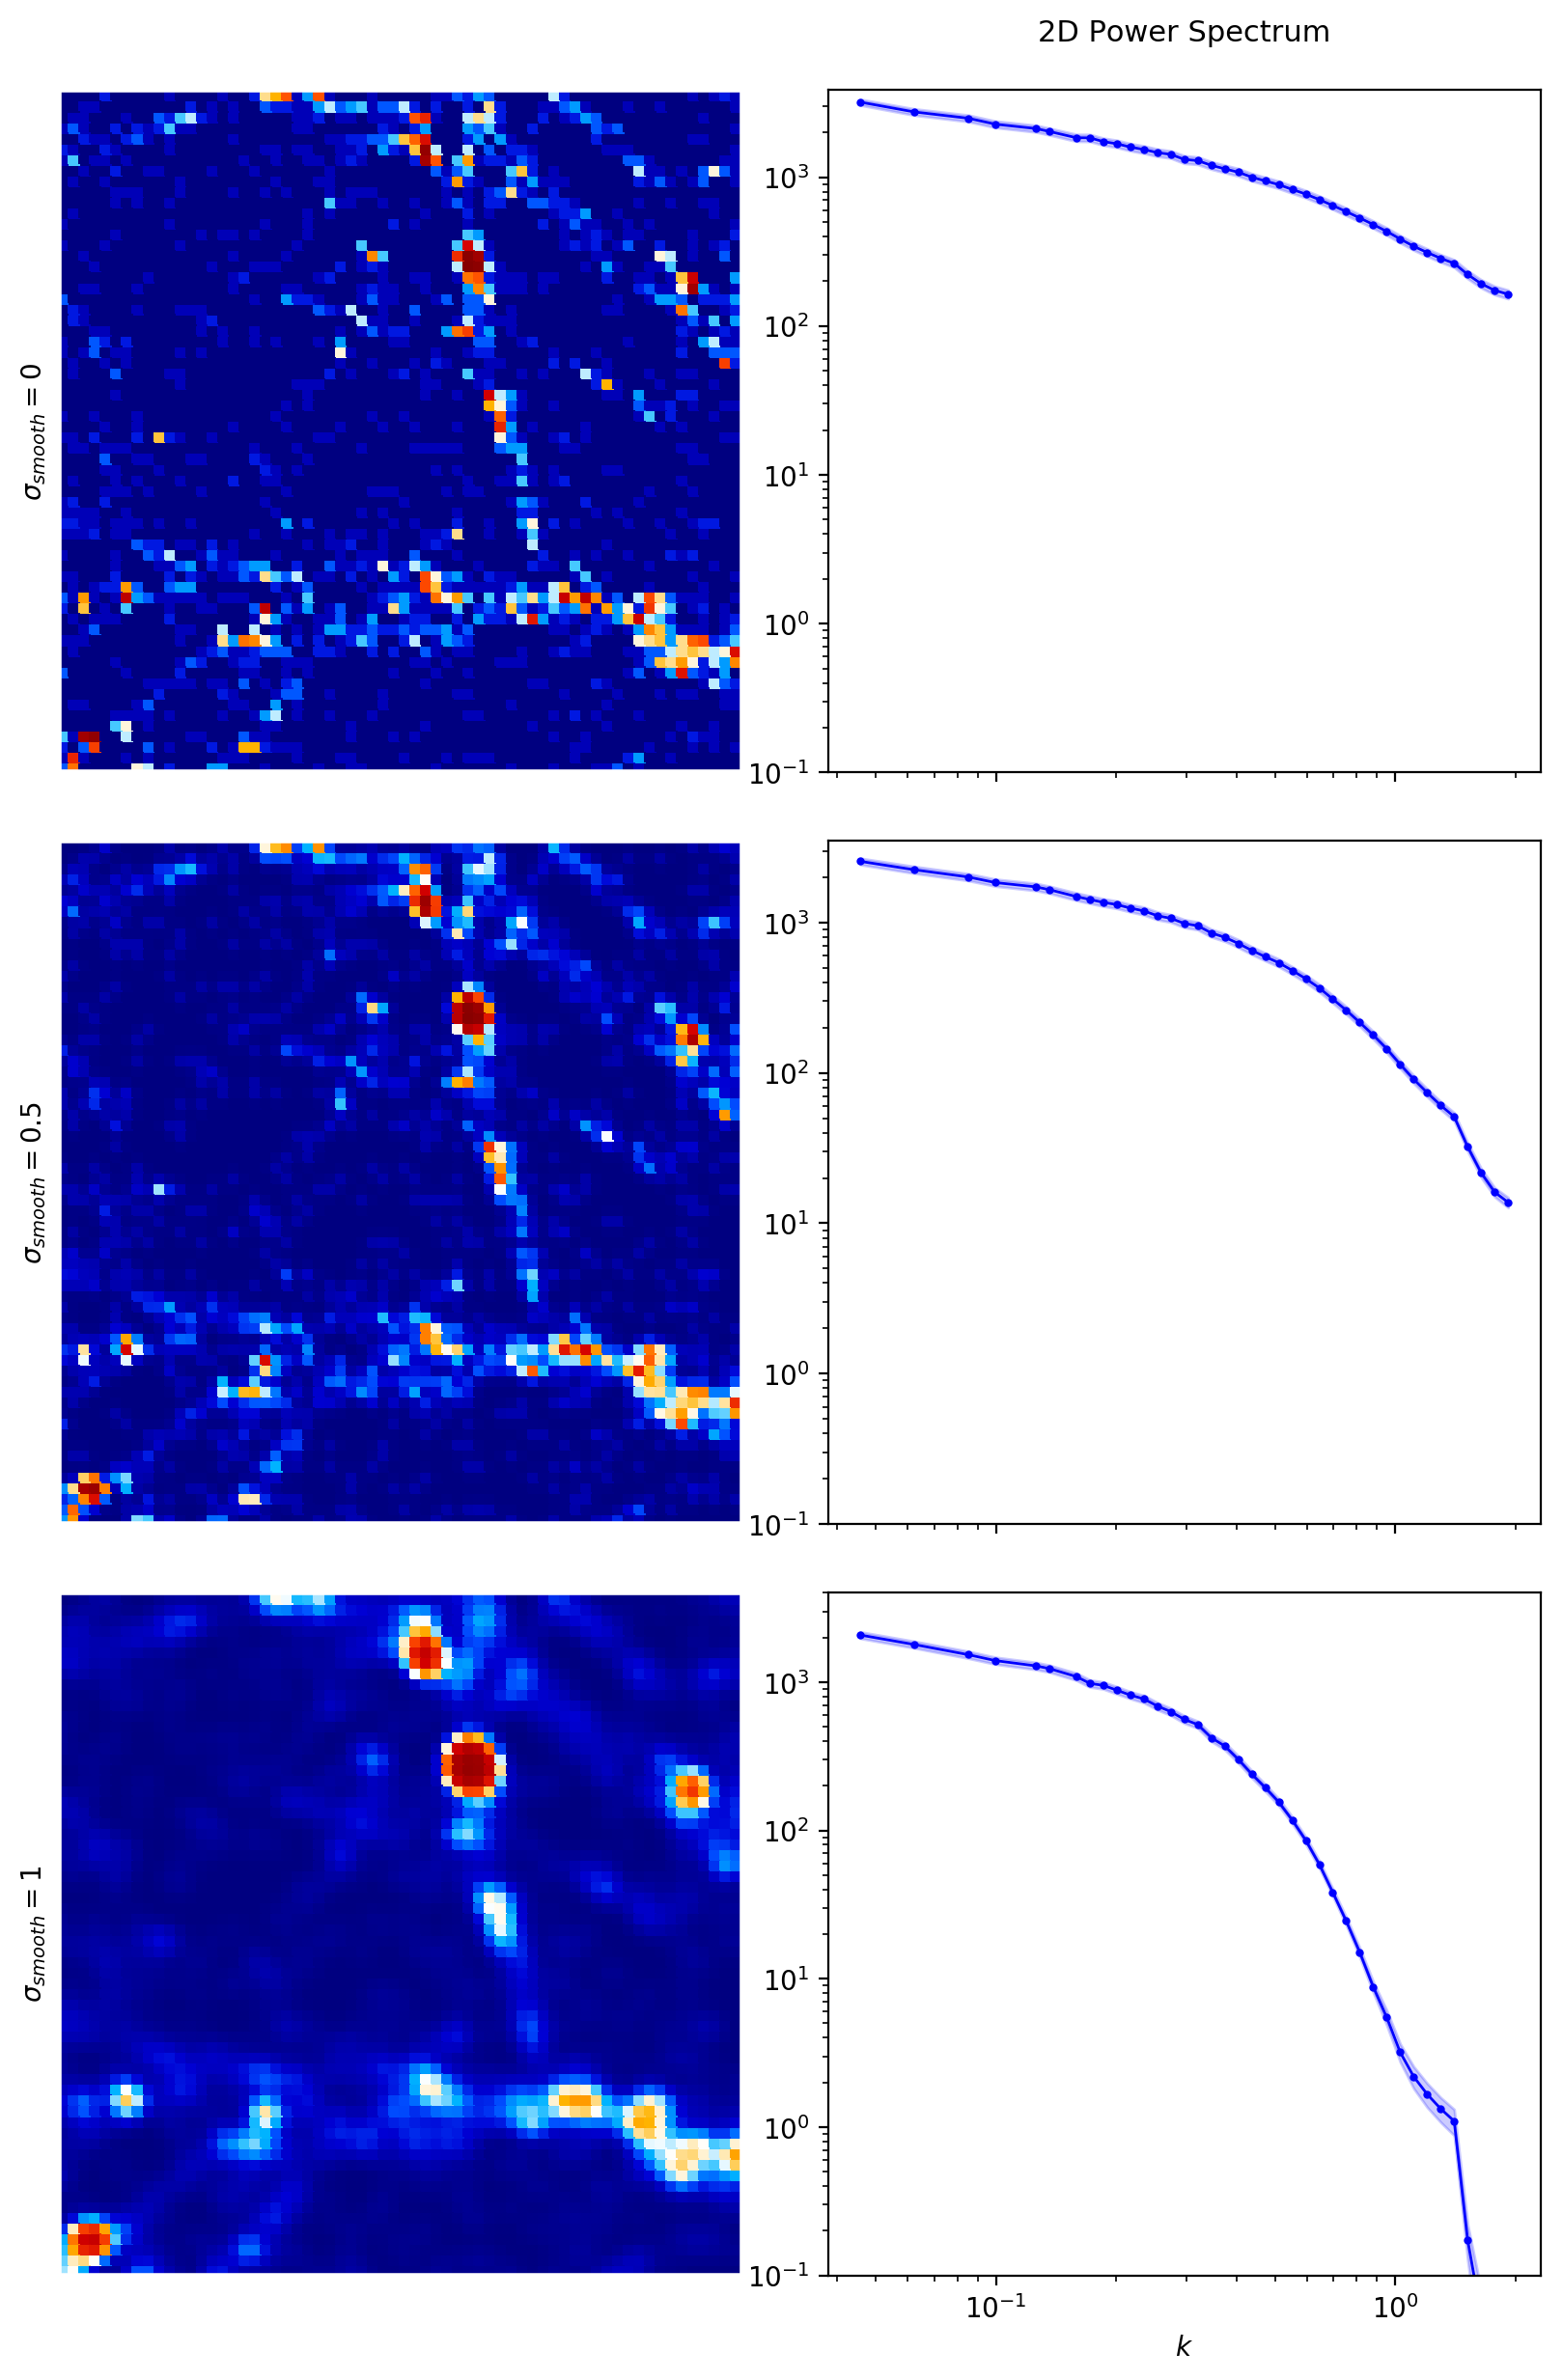

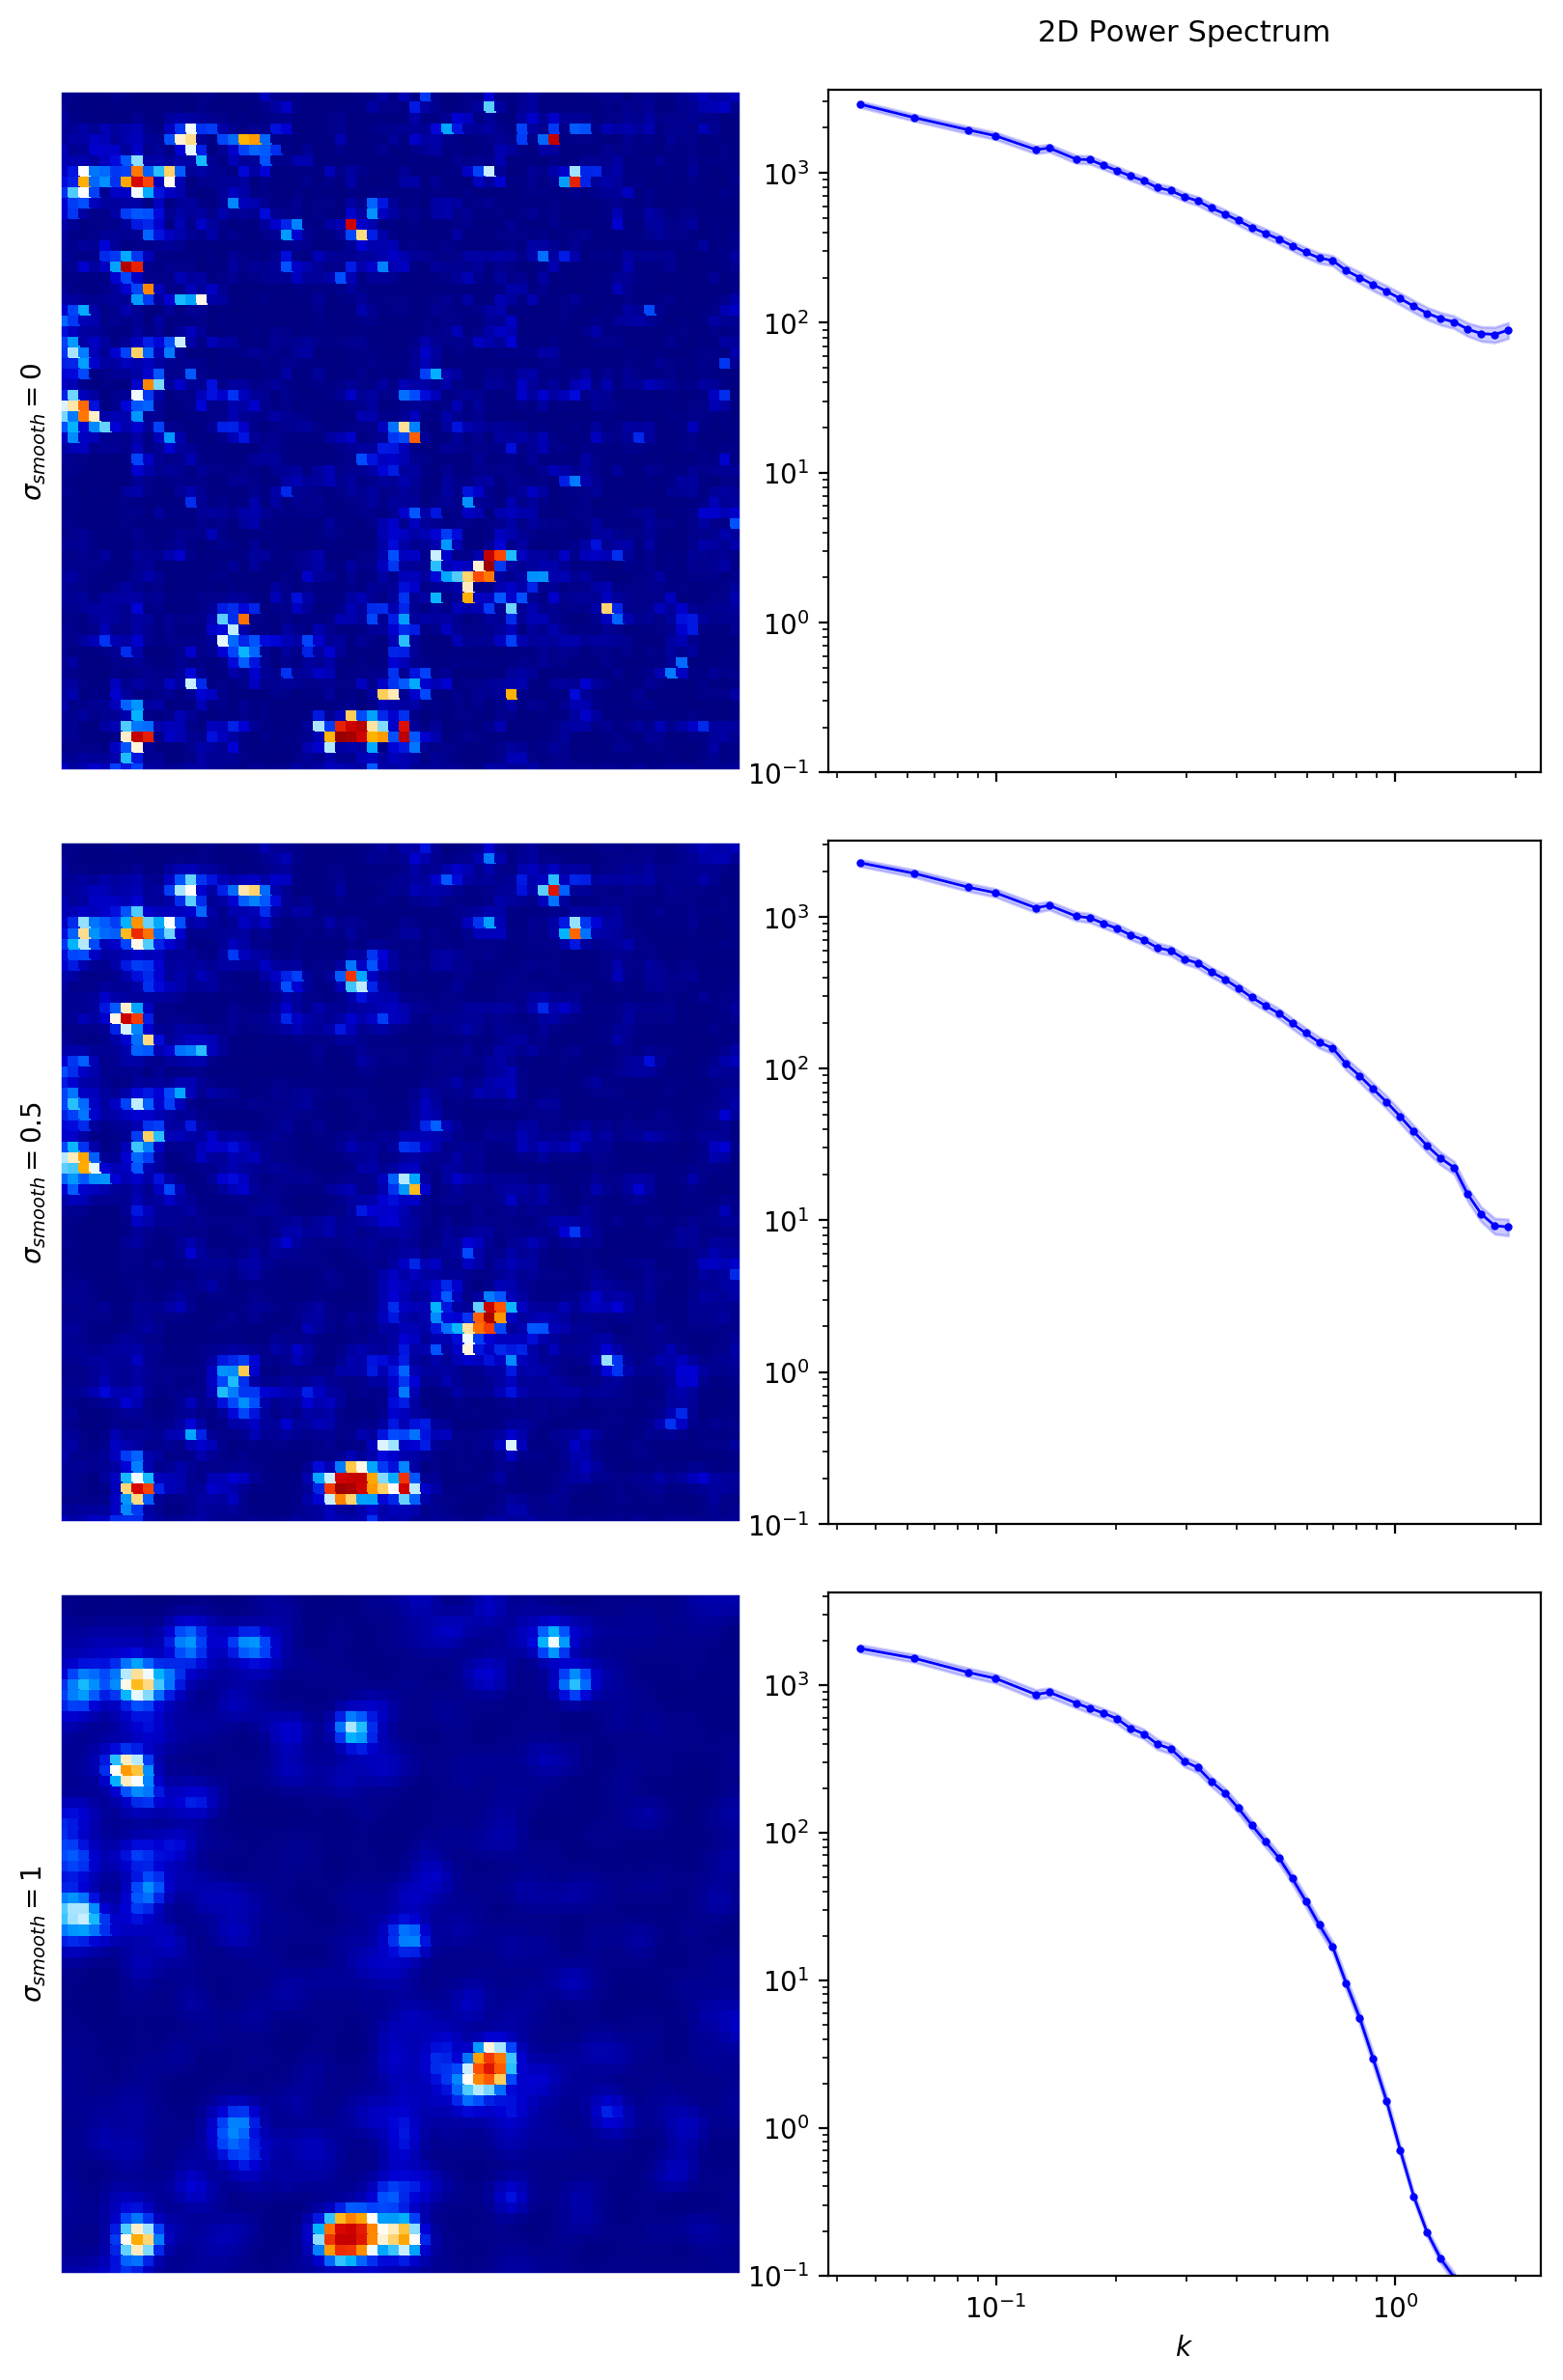

In [16]:
import plot
sigma_smooth = [0,0.5,1]

plot.plot_images_psd(real_sample_raw,'' , sigma_smooth = sigma_smooth)
plot.plot_images_psd(gen_sample_raw,'' , sigma_smooth = sigma_smooth)

In [37]:
(np.mean(psd_gen[psd_gen<0])**2 )

/data/.virtualenvs/fma/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/.virtualenvs/fma/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan